<a href="https://colab.research.google.com/github/sreenithi/QuickDraw-CNN/blob/main/Sketcher.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# QuickDraw-CNN
## Get the Class names 

This file contains a subset of the quick draw classes. I choose around 3 classes from the dataset. 

In [1]:
# !wget 'https://raw.githubusercontent.com/googlecreativelab/quickdraw-dataset/master/categories.txt'
!wget 'https://raw.githubusercontent.com/benjaminjacobreji/quickdraw-cnn-demo/main/fruits.txt'

--2021-05-20 10:35:22--  https://raw.githubusercontent.com/benjaminjacobreji/quickdraw-cnn-demo/main/fruits.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 24 [text/plain]
Saving to: ‘fruits.txt’

fruits.txt          100%[===================>]      24  --.-KB/s    in 0s      

2021-05-20 10:35:22 (1.21 MB/s) - ‘fruits.txt’ saved [24/24]



Read the classes names 

In [2]:
f = open("fruits.txt","r")
# And for reading use
classes = f.readlines()
f.close()

In [3]:
classes = [c.replace('\n','').replace(' ','_') for c in classes]
for item in classes:
    print(item)

apple
banana
strawberry


# Download the Dataset 

Loop over the classes and download the currospondent data

In [4]:
!mkdir data

In [5]:
import urllib.request
def download():
  
  base = 'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/'
  for c in classes:
    cls_url = c.replace('_', '%20')
    path = base+cls_url+'.npy'
    print(path)
    urllib.request.urlretrieve(path, 'data/'+c+'.npy')

In [6]:
download() 

https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/apple.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/banana.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/strawberry.npy


# Imports 

In [7]:
import os
import glob
import numpy as np
from tensorflow.keras import layers
from tensorflow import keras 
import tensorflow as tf

# Load the Data 

Each class contains different number samples of arrays stored as .npy format. Since we have some memory limitations we only load 5000 images per class.  

In [16]:
def load_data(root, vfold_ratio=0.2, max_items_per_class= 5000 ):
    all_files = glob.glob(os.path.join(root, '*.npy'))

    #initialize variables 
    x = np.empty([0, 784])
    y = np.empty([0])
    class_names = []

    #load each data file 
    for idx, file in enumerate(all_files):
        data = np.load(file)
        data = data[0: max_items_per_class, :]
        labels = np.full(data.shape[0], idx)

        x = np.concatenate((x, data), axis=0)
        y = np.append(y, labels)

        class_name, ext = os.path.splitext(os.path.basename(file))
        class_names.append(class_name)

    data = None
    labels = None
    
    #randomize the dataset 
    permutation = np.random.permutation(y.shape[0])
    x = x[permutation, :]
    y = y[permutation]

    #separate into training and testing 
    vfold_size = int(x.shape[0]/100*(vfold_ratio*100))

    x_test = x[0:vfold_size, :]
    y_test = y[0:vfold_size]

    x_train = x[vfold_size:x.shape[0], :]
    y_train = y[vfold_size:y.shape[0]]
    return x_train, y_train, x_test, y_test, class_names

In [17]:
x_train, y_train, x_test, y_test, class_names = load_data('data')
num_classes = len(class_names)
image_size = 28

In [22]:
print(class_names)

['banana', 'apple', 'strawberry']


In [21]:
images = dict()
count = 0
for i in range(len(x_train)):
    if images.get(y_train[i]) is None:
        images[y_train[i]] = [x_train[i]]
        count += 1
    elif len(images.get(y_train[i])) < 3:
        images[y_train[i]].append(x_train[i])
        count += 1
    if count == 9:
        break

1.0 : 3
0.0 : 3
2.0 : 3


In [32]:
print(len(x_train))

12000


Show some random data 

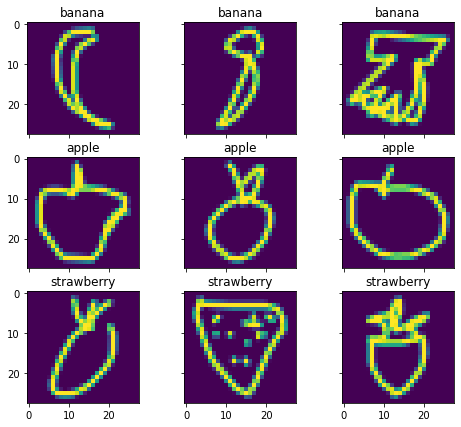

In [34]:
import matplotlib.pyplot as plt
from random import randint
%matplotlib inline

fig, ax = plt.subplots(3,3, figsize=(8, 7), sharey=True, sharex=True)

for i in range(3):
    per_class_images = images.get(float(i))
    for j in range(3):
        ax[i,j].set_title(class_names[i])
        # col_name = n_cols[i*3+j]
        ax[i,j].imshow(per_class_images[j].reshape(28,28))

plt.show()

# idx = randint(0, len(x_train))
# plt.imshow(x_train[idx].reshape(28,28)) 
# print(class_names[int(y_train[idx].item())])

# Preprocess the Data 

In [36]:
# Reshape and normalize
x_train = x_train.reshape(x_train.shape[0], image_size, image_size, 1).astype('float32')
x_test = x_test.reshape(x_test.shape[0], image_size, image_size, 1).astype('float32')

x_train /= 255.0
x_test /= 255.0

# Convert class vectors to class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# The Model 

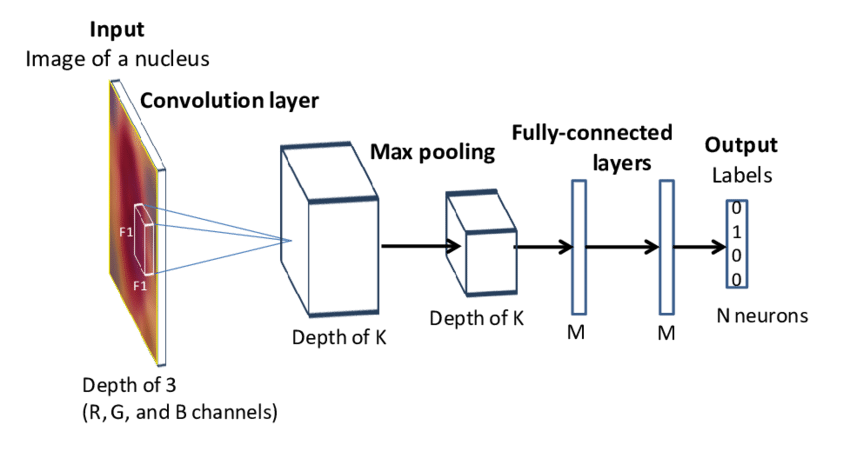

In [37]:
# Define model
model = keras.Sequential()
model.add(layers.Convolution2D(16, (3, 3),
                        padding='same',
                        input_shape=x_train.shape[1:], activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Convolution2D(32, (3, 3), padding='same', activation= 'relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Convolution2D(64, (3, 3), padding='same', activation= 'relu'))
model.add(layers.MaxPooling2D(pool_size =(2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(3, activation='softmax')) 
# Train model
adam = tf.keras.optimizers.Adam()
model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['top_k_categorical_accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 3, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 576)               0

# Training 

In [38]:
model.fit(x = x_train, y = y_train, validation_split=0.1, batch_size = 256, verbose=2, epochs=15)

Epoch 1/15
43/43 - 31s - loss: 0.4536 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.2167 - val_top_k_categorical_accuracy: 1.0000
Epoch 2/15
43/43 - 0s - loss: 0.2138 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.1656 - val_top_k_categorical_accuracy: 1.0000
Epoch 3/15
43/43 - 0s - loss: 0.1795 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.1528 - val_top_k_categorical_accuracy: 1.0000
Epoch 4/15
43/43 - 0s - loss: 0.1577 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.1424 - val_top_k_categorical_accuracy: 1.0000
Epoch 5/15
43/43 - 0s - loss: 0.1417 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.1339 - val_top_k_categorical_accuracy: 1.0000
Epoch 6/15
43/43 - 0s - loss: 0.1298 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.1420 - val_top_k_categorical_accuracy: 1.0000
Epoch 7/15
43/43 - 0s - loss: 0.1211 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.1317 - val_top_k_categorical_accuracy: 1.0000
Epoch 8/15
43/43 - 0s - loss: 0.1053 - top_k_categorical_accu

# Testing 

In [39]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test accuarcy: {:0.2f}%'.format(score[1] * 100))

Test accuarcy: 100.00%


# Inference 

strawberry


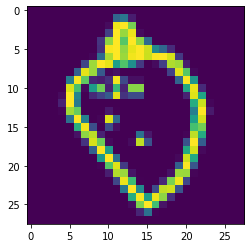

In [40]:
import matplotlib.pyplot as plt
from random import randint
%matplotlib inline  
idx = randint(0, len(x_test))
img = x_test[idx]
plt.imshow(img.squeeze()) 
pred = model.predict(np.expand_dims(img, axis=0))[0]
ind = (-pred).argsort()[:5]
latex = [class_names[x] for x in ind]
print(latex[0])

# Store the classes 

In [41]:
with open('class_names.txt', 'w') as file_handler:
    for item in class_names:
        file_handler.write("{}\n".format(item))

# Install TensorFlowJS

In [42]:
!pip install tensorflowjs 

     |████████████████████████████████| 71kB 5.3MB/s 
     |████████████████████████████████| 112kB 16.7MB/s 
  Found existing installation: tensorflow-hub 0.12.0
    Uninstalling tensorflow-hub-0.12.0:
      Successfully uninstalled tensorflow-hub-0.12.0


# Save and Convert 

In [43]:
model.save('keras.h5')

In [44]:
!mkdir model
!tensorflowjs_converter --input_format keras keras.h5 model/

2021-05-20 11:46:00.510200: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


# Zip and Download 

In [45]:
!cp class_names.txt model/class_names.txt

In [46]:
!zip -r model.zip model 

  adding: model/ (stored 0%)
  adding: model/class_names.txt (stored 0%)
  adding: model/model.json (deflated 82%)
  adding: model/group1-shard1of1.bin (deflated 8%)
